# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    # TODO: Implement function and return a dataloader

    # transform, resize and to tensor
    transform = transforms.Compose([transforms.Resize((image_size[0], image_size[1])), 
                                    transforms.ToTensor()])
    data = datasets.ImageFolder(root=data_dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = [32, 32]

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

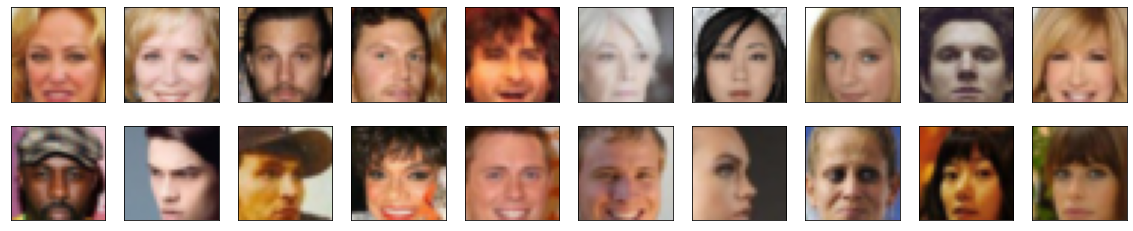

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8745)
Max:  tensor(0.9216)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 3x32x32 -> 128x16x16
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 128x16x16 -> 256x8x8
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        # 256x8x8 -> 512x4x4
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim * 4 * 4 * 4, 1)        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim * 4 * 4 * 4)
        
        # final output layer
        x = self.fc(x)          
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)
        # transpose conv layers
        # 512x4x4 -> 256x8x8
        self.t_conv1 = deconv(conv_dim * 4, conv_dim * 2, 4)
        # 256x8x8 -> 128x16x16
        self.t_conv2 = deconv(conv_dim * 2, conv_dim, 4)
        # 128x16x16 -> 3x32x32
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior

        # fully-connected + reshape
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 4, 4, 4) # batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = torch.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    #  for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0 / np.sqrt(n))
        m.weight.data.normal_(0, y) # weight is normal distribution
        m.bias.data.fill_(0)        # bias is all 0

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim
# params
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # 1.1 Train with real images
            d_optimizer.zero_grad()
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 1.2 Train with fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            # 2.1 Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.7170 | g_loss: 0.9355
Epoch [    1/   50] | d_loss: 0.0683 | g_loss: 3.5060
Epoch [    1/   50] | d_loss: 0.0255 | g_loss: 4.4359
Epoch [    1/   50] | d_loss: 0.0432 | g_loss: 4.4420
Epoch [    1/   50] | d_loss: 0.5642 | g_loss: 1.6915
Epoch [    1/   50] | d_loss: 0.1013 | g_loss: 4.2582
Epoch [    1/   50] | d_loss: 0.1457 | g_loss: 3.0928
Epoch [    1/   50] | d_loss: 0.1756 | g_loss: 3.5020
Epoch [    1/   50] | d_loss: 1.8251 | g_loss: 1.2270
Epoch [    1/   50] | d_loss: 0.2417 | g_loss: 3.0664
Epoch [    1/   50] | d_loss: 0.0655 | g_loss: 3.3851
Epoch [    1/   50] | d_loss: 0.4270 | g_loss: 3.4937
Epoch [    1/   50] | d_loss: 0.3348 | g_loss: 1.5013
Epoch [    1/   50] | d_loss: 0.2760 | g_loss: 3.5848
Epoch [    1/   50] | d_loss: 0.4439 | g_loss: 3.4191
Epoch [    1/   50] | d_loss: 0.5966 | g_loss: 2.8249
Epoch [    1/   50] | d_loss: 0.7752 | g_loss: 1.4428
Epoch [    1/   50] | d_loss: 0.2664 | g_loss: 2.3851
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.3662 | g_loss: 1.9505
Epoch [    3/   50] | d_loss: 0.4045 | g_loss: 2.5125
Epoch [    3/   50] | d_loss: 0.2563 | g_loss: 3.3816
Epoch [    3/   50] | d_loss: 0.5531 | g_loss: 1.5589
Epoch [    3/   50] | d_loss: 0.4400 | g_loss: 3.0242
Epoch [    3/   50] | d_loss: 0.3931 | g_loss: 2.1639
Epoch [    3/   50] | d_loss: 0.6489 | g_loss: 3.0961
Epoch [    3/   50] | d_loss: 0.4643 | g_loss: 3.0455
Epoch [    3/   50] | d_loss: 0.6638 | g_loss: 1.6417
Epoch [    3/   50] | d_loss: 0.5237 | g_loss: 1.1900
Epoch [    3/   50] | d_loss: 0.8050 | g_loss: 1.3503
Epoch [    3/   50] | d_loss: 0.6796 | g_loss: 2.5716
Epoch [    3/   50] | d_loss: 0.5634 | g_loss: 2.2944
Epoch [    3/   50] | d_loss: 0.4882 | g_loss: 2.7778
Epoch [    3/   50] | d_loss: 0.4635 | g_loss: 1.5855
Epoch [    3/   50] | d_loss: 0.6254 | g_loss: 1.6270
Epoch [    3/   50] | d_loss: 0.4247 | g_loss: 1.0995
Epoch [    3/   50] | d_loss: 0.5642 | g_loss: 1.1125
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.2255 | g_loss: 3.9960
Epoch [    6/   50] | d_loss: 0.1895 | g_loss: 2.1609
Epoch [    6/   50] | d_loss: 0.3622 | g_loss: 1.1646
Epoch [    6/   50] | d_loss: 1.6676 | g_loss: 4.0216
Epoch [    6/   50] | d_loss: 0.5360 | g_loss: 2.9165
Epoch [    6/   50] | d_loss: 0.5605 | g_loss: 1.7337
Epoch [    6/   50] | d_loss: 0.2274 | g_loss: 2.5583
Epoch [    6/   50] | d_loss: 0.3366 | g_loss: 2.9838
Epoch [    6/   50] | d_loss: 0.7833 | g_loss: 1.7137
Epoch [    6/   50] | d_loss: 0.4904 | g_loss: 1.8697
Epoch [    6/   50] | d_loss: 0.4510 | g_loss: 4.6623
Epoch [    6/   50] | d_loss: 0.3021 | g_loss: 2.8296
Epoch [    6/   50] | d_loss: 0.2758 | g_loss: 2.5124
Epoch [    6/   50] | d_loss: 0.3772 | g_loss: 2.9632
Epoch [    6/   50] | d_loss: 0.1987 | g_loss: 3.5018
Epoch [    6/   50] | d_loss: 0.3472 | g_loss: 2.5853
Epoch [    6/   50] | d_loss: 0.2111 | g_loss: 3.1653
Epoch [    6/   50] | d_loss: 0.2670 | g_loss: 3.5214
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.2297 | g_loss: 3.7825
Epoch [    9/   50] | d_loss: 0.2034 | g_loss: 3.2770
Epoch [    9/   50] | d_loss: 0.1813 | g_loss: 3.7508
Epoch [    9/   50] | d_loss: 0.3078 | g_loss: 2.3937
Epoch [    9/   50] | d_loss: 0.4658 | g_loss: 2.5068
Epoch [    9/   50] | d_loss: 0.2323 | g_loss: 2.3132
Epoch [    9/   50] | d_loss: 0.3988 | g_loss: 3.8645
Epoch [    9/   50] | d_loss: 0.2027 | g_loss: 2.6507
Epoch [    9/   50] | d_loss: 0.1607 | g_loss: 4.0391
Epoch [    9/   50] | d_loss: 0.5274 | g_loss: 2.9573
Epoch [    9/   50] | d_loss: 0.1439 | g_loss: 2.7085
Epoch [    9/   50] | d_loss: 0.2728 | g_loss: 3.9501
Epoch [    9/   50] | d_loss: 0.2067 | g_loss: 2.8939
Epoch [    9/   50] | d_loss: 0.3250 | g_loss: 3.8962
Epoch [    9/   50] | d_loss: 0.1733 | g_loss: 3.7534
Epoch [    9/   50] | d_loss: 0.1903 | g_loss: 3.7489
Epoch [    9/   50] | d_loss: 0.2565 | g_loss: 2.8666
Epoch [    9/   50] | d_loss: 0.2011 | g_loss: 2.7596
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.6580 | g_loss: 4.7479
Epoch [   11/   50] | d_loss: 0.3184 | g_loss: 3.7604
Epoch [   11/   50] | d_loss: 0.3867 | g_loss: 2.9976
Epoch [   11/   50] | d_loss: 4.4555 | g_loss: 6.5953
Epoch [   11/   50] | d_loss: 0.2785 | g_loss: 3.6130
Epoch [   11/   50] | d_loss: 0.2236 | g_loss: 1.4616
Epoch [   11/   50] | d_loss: 0.1565 | g_loss: 3.9489
Epoch [   11/   50] | d_loss: 0.3410 | g_loss: 4.5444
Epoch [   11/   50] | d_loss: 0.2838 | g_loss: 2.1396
Epoch [   11/   50] | d_loss: 0.3825 | g_loss: 3.2920
Epoch [   11/   50] | d_loss: 0.1739 | g_loss: 3.6318
Epoch [   11/   50] | d_loss: 0.1702 | g_loss: 2.9481
Epoch [   11/   50] | d_loss: 0.4846 | g_loss: 2.4469
Epoch [   11/   50] | d_loss: 0.4525 | g_loss: 4.1248
Epoch [   11/   50] | d_loss: 0.7823 | g_loss: 1.1955
Epoch [   11/   50] | d_loss: 0.2299 | g_loss: 4.8310
Epoch [   11/   50] | d_loss: 0.1655 | g_loss: 2.2222
Epoch [   11/   50] | d_loss: 0.1221 | g_loss: 3.2132
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.3507 | g_loss: 4.1151
Epoch [   14/   50] | d_loss: 0.1022 | g_loss: 2.4332
Epoch [   14/   50] | d_loss: 0.1760 | g_loss: 2.4401
Epoch [   14/   50] | d_loss: 0.3671 | g_loss: 2.1689
Epoch [   14/   50] | d_loss: 0.6343 | g_loss: 2.4187
Epoch [   14/   50] | d_loss: 0.1541 | g_loss: 4.1454
Epoch [   14/   50] | d_loss: 0.2787 | g_loss: 3.4758
Epoch [   14/   50] | d_loss: 0.4432 | g_loss: 2.7285
Epoch [   14/   50] | d_loss: 0.1651 | g_loss: 4.4456
Epoch [   14/   50] | d_loss: 0.2451 | g_loss: 3.4899
Epoch [   14/   50] | d_loss: 0.5044 | g_loss: 3.4454
Epoch [   14/   50] | d_loss: 1.2596 | g_loss: 5.0630
Epoch [   14/   50] | d_loss: 0.0935 | g_loss: 2.3468
Epoch [   14/   50] | d_loss: 0.1821 | g_loss: 3.2159
Epoch [   14/   50] | d_loss: 0.1435 | g_loss: 3.9406
Epoch [   14/   50] | d_loss: 0.1253 | g_loss: 5.7268
Epoch [   14/   50] | d_loss: 0.2018 | g_loss: 3.5210
Epoch [   14/   50] | d_loss: 0.2641 | g_loss: 2.3731
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.4835 | g_loss: 2.9551
Epoch [   17/   50] | d_loss: 0.1545 | g_loss: 4.4130
Epoch [   17/   50] | d_loss: 0.0998 | g_loss: 3.3698
Epoch [   17/   50] | d_loss: 0.1360 | g_loss: 4.4893
Epoch [   17/   50] | d_loss: 0.1045 | g_loss: 3.1509
Epoch [   17/   50] | d_loss: 0.1044 | g_loss: 3.4841
Epoch [   17/   50] | d_loss: 0.2277 | g_loss: 3.1333
Epoch [   17/   50] | d_loss: 0.2349 | g_loss: 4.1861
Epoch [   17/   50] | d_loss: 0.1465 | g_loss: 4.0558
Epoch [   17/   50] | d_loss: 0.2886 | g_loss: 3.1557
Epoch [   17/   50] | d_loss: 0.2612 | g_loss: 1.7188
Epoch [   17/   50] | d_loss: 0.8434 | g_loss: 3.7802
Epoch [   17/   50] | d_loss: 0.1570 | g_loss: 3.7754
Epoch [   17/   50] | d_loss: 0.2033 | g_loss: 3.3893
Epoch [   17/   50] | d_loss: 0.1663 | g_loss: 2.0283
Epoch [   17/   50] | d_loss: 0.1220 | g_loss: 3.9575
Epoch [   17/   50] | d_loss: 0.2718 | g_loss: 5.5562
Epoch [   17/   50] | d_loss: 0.1783 | g_loss: 5.4291
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.7401 | g_loss: 1.8927
Epoch [   19/   50] | d_loss: 0.1032 | g_loss: 3.5140
Epoch [   19/   50] | d_loss: 0.3330 | g_loss: 2.3021
Epoch [   19/   50] | d_loss: 0.1249 | g_loss: 4.6716
Epoch [   19/   50] | d_loss: 0.1089 | g_loss: 3.9294
Epoch [   19/   50] | d_loss: 0.5932 | g_loss: 2.4739
Epoch [   19/   50] | d_loss: 0.0731 | g_loss: 4.1513
Epoch [   19/   50] | d_loss: 0.2749 | g_loss: 4.6990
Epoch [   19/   50] | d_loss: 0.4004 | g_loss: 3.0612
Epoch [   19/   50] | d_loss: 0.0917 | g_loss: 2.8689
Epoch [   19/   50] | d_loss: 0.1246 | g_loss: 3.2641
Epoch [   19/   50] | d_loss: 0.3629 | g_loss: 2.5405
Epoch [   19/   50] | d_loss: 0.0932 | g_loss: 3.2247
Epoch [   19/   50] | d_loss: 0.2960 | g_loss: 4.0967
Epoch [   19/   50] | d_loss: 0.1656 | g_loss: 3.8753
Epoch [   19/   50] | d_loss: 0.3084 | g_loss: 4.4375
Epoch [   19/   50] | d_loss: 0.1428 | g_loss: 4.0586
Epoch [   19/   50] | d_loss: 0.4092 | g_loss: 3.4774
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.1336 | g_loss: 4.1723
Epoch [   22/   50] | d_loss: 0.5322 | g_loss: 5.3519
Epoch [   22/   50] | d_loss: 0.1020 | g_loss: 4.1147
Epoch [   22/   50] | d_loss: 0.1587 | g_loss: 3.8486
Epoch [   22/   50] | d_loss: 0.0463 | g_loss: 3.7154
Epoch [   22/   50] | d_loss: 0.1599 | g_loss: 4.2068
Epoch [   22/   50] | d_loss: 0.1460 | g_loss: 4.9499
Epoch [   22/   50] | d_loss: 0.0962 | g_loss: 3.8959
Epoch [   22/   50] | d_loss: 0.1854 | g_loss: 5.1584
Epoch [   22/   50] | d_loss: 0.0461 | g_loss: 6.2276
Epoch [   22/   50] | d_loss: 0.0914 | g_loss: 5.4733
Epoch [   22/   50] | d_loss: 0.1510 | g_loss: 4.7234
Epoch [   22/   50] | d_loss: 0.0913 | g_loss: 3.9613
Epoch [   22/   50] | d_loss: 1.0254 | g_loss: 9.0383
Epoch [   22/   50] | d_loss: 0.1358 | g_loss: 4.8859
Epoch [   22/   50] | d_loss: 0.1514 | g_loss: 2.7744
Epoch [   22/   50] | d_loss: 0.0896 | g_loss: 4.1575
Epoch [   22/   50] | d_loss: 0.1102 | g_loss: 6.7189
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0521 | g_loss: 4.2101
Epoch [   25/   50] | d_loss: 0.4419 | g_loss: 3.7915
Epoch [   25/   50] | d_loss: 0.1260 | g_loss: 3.9759
Epoch [   25/   50] | d_loss: 0.3167 | g_loss: 3.3124
Epoch [   25/   50] | d_loss: 0.1334 | g_loss: 5.3366
Epoch [   25/   50] | d_loss: 0.0202 | g_loss: 5.8446
Epoch [   25/   50] | d_loss: 0.0217 | g_loss: 5.6733
Epoch [   25/   50] | d_loss: 0.1331 | g_loss: 6.1411
Epoch [   25/   50] | d_loss: 0.3557 | g_loss: 4.9942
Epoch [   25/   50] | d_loss: 0.1138 | g_loss: 5.1729
Epoch [   25/   50] | d_loss: 0.0634 | g_loss: 3.1169
Epoch [   25/   50] | d_loss: 0.3302 | g_loss: 3.6809
Epoch [   25/   50] | d_loss: 0.5192 | g_loss: 2.3464
Epoch [   25/   50] | d_loss: 0.1914 | g_loss: 3.1460
Epoch [   25/   50] | d_loss: 0.2817 | g_loss: 4.3695
Epoch [   25/   50] | d_loss: 0.1030 | g_loss: 3.2235
Epoch [   25/   50] | d_loss: 0.9640 | g_loss: 1.5686
Epoch [   25/   50] | d_loss: 0.3767 | g_loss: 3.0529
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.1545 | g_loss: 4.9700
Epoch [   27/   50] | d_loss: 0.5902 | g_loss: 4.6924
Epoch [   27/   50] | d_loss: 0.1258 | g_loss: 3.5358
Epoch [   27/   50] | d_loss: 0.0830 | g_loss: 4.2213
Epoch [   27/   50] | d_loss: 0.0432 | g_loss: 5.2234
Epoch [   27/   50] | d_loss: 0.3251 | g_loss: 4.6904
Epoch [   27/   50] | d_loss: 0.1416 | g_loss: 5.4821
Epoch [   27/   50] | d_loss: 0.1445 | g_loss: 3.2049
Epoch [   27/   50] | d_loss: 0.0874 | g_loss: 5.3117
Epoch [   27/   50] | d_loss: 0.4557 | g_loss: 3.4813
Epoch [   27/   50] | d_loss: 0.2471 | g_loss: 3.5364
Epoch [   27/   50] | d_loss: 0.1771 | g_loss: 5.4059
Epoch [   27/   50] | d_loss: 0.2047 | g_loss: 3.6318
Epoch [   27/   50] | d_loss: 0.2341 | g_loss: 2.2904
Epoch [   27/   50] | d_loss: 0.0954 | g_loss: 4.4077
Epoch [   27/   50] | d_loss: 0.1352 | g_loss: 6.1791
Epoch [   27/   50] | d_loss: 0.0953 | g_loss: 4.5744
Epoch [   27/   50] | d_loss: 0.2342 | g_loss: 4.2908
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.1754 | g_loss: 6.2050
Epoch [   30/   50] | d_loss: 0.1379 | g_loss: 4.6074
Epoch [   30/   50] | d_loss: 0.1931 | g_loss: 4.9847
Epoch [   30/   50] | d_loss: 0.1715 | g_loss: 4.3550
Epoch [   30/   50] | d_loss: 0.1283 | g_loss: 5.2175
Epoch [   30/   50] | d_loss: 0.1375 | g_loss: 6.3688
Epoch [   30/   50] | d_loss: 0.2579 | g_loss: 4.1856
Epoch [   30/   50] | d_loss: 0.0679 | g_loss: 5.1544
Epoch [   30/   50] | d_loss: 0.0074 | g_loss: 5.3423
Epoch [   30/   50] | d_loss: 0.0569 | g_loss: 4.8675
Epoch [   30/   50] | d_loss: 0.2829 | g_loss: 3.8435
Epoch [   30/   50] | d_loss: 0.0345 | g_loss: 5.2501
Epoch [   30/   50] | d_loss: 0.1518 | g_loss: 4.1181
Epoch [   30/   50] | d_loss: 0.2486 | g_loss: 4.3096
Epoch [   30/   50] | d_loss: 0.0845 | g_loss: 5.6138
Epoch [   30/   50] | d_loss: 0.3562 | g_loss: 7.1281
Epoch [   30/   50] | d_loss: 0.0697 | g_loss: 4.3506
Epoch [   30/   50] | d_loss: 0.1531 | g_loss: 4.7748
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.1349 | g_loss: 3.9679
Epoch [   33/   50] | d_loss: 0.0415 | g_loss: 6.1694
Epoch [   33/   50] | d_loss: 0.0380 | g_loss: 4.6065
Epoch [   33/   50] | d_loss: 0.0792 | g_loss: 4.9723
Epoch [   33/   50] | d_loss: 0.0777 | g_loss: 4.7954
Epoch [   33/   50] | d_loss: 0.1266 | g_loss: 5.5530
Epoch [   33/   50] | d_loss: 0.0859 | g_loss: 3.7214
Epoch [   33/   50] | d_loss: 0.0982 | g_loss: 6.4394
Epoch [   33/   50] | d_loss: 0.1086 | g_loss: 5.2135
Epoch [   33/   50] | d_loss: 0.1140 | g_loss: 4.9983
Epoch [   33/   50] | d_loss: 0.0417 | g_loss: 3.0729
Epoch [   33/   50] | d_loss: 0.3671 | g_loss: 3.0857
Epoch [   33/   50] | d_loss: 0.4003 | g_loss: 2.4174
Epoch [   33/   50] | d_loss: 0.4945 | g_loss: 3.5862
Epoch [   33/   50] | d_loss: 0.1764 | g_loss: 4.7559
Epoch [   33/   50] | d_loss: 0.0355 | g_loss: 5.8121
Epoch [   33/   50] | d_loss: 0.1830 | g_loss: 4.6388
Epoch [   33/   50] | d_loss: 0.3511 | g_loss: 3.5036
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.1368 | g_loss: 4.2860
Epoch [   35/   50] | d_loss: 0.1935 | g_loss: 3.6770
Epoch [   35/   50] | d_loss: 0.0733 | g_loss: 4.9268
Epoch [   35/   50] | d_loss: 0.1433 | g_loss: 5.6458
Epoch [   35/   50] | d_loss: 0.3150 | g_loss: 3.5023
Epoch [   35/   50] | d_loss: 0.1166 | g_loss: 5.2895
Epoch [   35/   50] | d_loss: 0.0753 | g_loss: 6.4907
Epoch [   35/   50] | d_loss: 0.1371 | g_loss: 3.8062
Epoch [   35/   50] | d_loss: 0.2110 | g_loss: 7.2168
Epoch [   35/   50] | d_loss: 0.0963 | g_loss: 6.0103
Epoch [   35/   50] | d_loss: 0.0601 | g_loss: 5.2160
Epoch [   35/   50] | d_loss: 0.2076 | g_loss: 4.9511
Epoch [   35/   50] | d_loss: 0.0737 | g_loss: 6.1358
Epoch [   35/   50] | d_loss: 0.0958 | g_loss: 5.7811
Epoch [   35/   50] | d_loss: 0.0418 | g_loss: 5.3148
Epoch [   35/   50] | d_loss: 0.0411 | g_loss: 5.5346
Epoch [   35/   50] | d_loss: 0.2029 | g_loss: 7.9933
Epoch [   35/   50] | d_loss: 0.3004 | g_loss: 4.3763
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0499 | g_loss: 6.0947
Epoch [   38/   50] | d_loss: 0.2462 | g_loss: 4.6450
Epoch [   38/   50] | d_loss: 0.0237 | g_loss: 4.6587
Epoch [   38/   50] | d_loss: 0.1405 | g_loss: 4.1201
Epoch [   38/   50] | d_loss: 0.0683 | g_loss: 4.8332
Epoch [   38/   50] | d_loss: 0.0308 | g_loss: 6.8863
Epoch [   38/   50] | d_loss: 0.2701 | g_loss: 4.8408
Epoch [   38/   50] | d_loss: 0.0958 | g_loss: 2.9322
Epoch [   38/   50] | d_loss: 0.2202 | g_loss: 6.0815
Epoch [   38/   50] | d_loss: 0.0806 | g_loss: 4.5849
Epoch [   38/   50] | d_loss: 0.0816 | g_loss: 4.4900
Epoch [   38/   50] | d_loss: 0.0896 | g_loss: 6.0487
Epoch [   38/   50] | d_loss: 0.0894 | g_loss: 3.8742
Epoch [   38/   50] | d_loss: 0.0115 | g_loss: 5.7641
Epoch [   38/   50] | d_loss: 0.0248 | g_loss: 2.9576
Epoch [   38/   50] | d_loss: 0.0783 | g_loss: 5.3619
Epoch [   38/   50] | d_loss: 0.1808 | g_loss: 4.1502
Epoch [   38/   50] | d_loss: 0.0453 | g_loss: 6.6845
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0472 | g_loss: 5.4285
Epoch [   41/   50] | d_loss: 0.2626 | g_loss: 5.4623
Epoch [   41/   50] | d_loss: 0.1305 | g_loss: 4.1462
Epoch [   41/   50] | d_loss: 0.0931 | g_loss: 4.8456
Epoch [   41/   50] | d_loss: 0.2555 | g_loss: 5.0776
Epoch [   41/   50] | d_loss: 0.1519 | g_loss: 7.0904
Epoch [   41/   50] | d_loss: 1.1254 | g_loss: 2.4607
Epoch [   41/   50] | d_loss: 0.0871 | g_loss: 5.6849
Epoch [   41/   50] | d_loss: 0.0803 | g_loss: 5.2178
Epoch [   41/   50] | d_loss: 0.0464 | g_loss: 6.0566
Epoch [   41/   50] | d_loss: 0.1749 | g_loss: 4.0892
Epoch [   41/   50] | d_loss: 0.1137 | g_loss: 4.2066
Epoch [   41/   50] | d_loss: 0.0630 | g_loss: 4.6130
Epoch [   41/   50] | d_loss: 0.0420 | g_loss: 4.5845
Epoch [   41/   50] | d_loss: 0.3481 | g_loss: 2.3100
Epoch [   41/   50] | d_loss: 0.1355 | g_loss: 4.9853
Epoch [   41/   50] | d_loss: 0.0685 | g_loss: 5.0197
Epoch [   41/   50] | d_loss: 0.0706 | g_loss: 6.6511
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 3.3338 | g_loss: 11.6106
Epoch [   43/   50] | d_loss: 0.0165 | g_loss: 6.7106
Epoch [   43/   50] | d_loss: 0.1189 | g_loss: 4.7095
Epoch [   43/   50] | d_loss: 0.0784 | g_loss: 3.7023
Epoch [   43/   50] | d_loss: 0.0498 | g_loss: 6.9630
Epoch [   43/   50] | d_loss: 0.1129 | g_loss: 5.9205
Epoch [   43/   50] | d_loss: 0.1076 | g_loss: 3.6294
Epoch [   43/   50] | d_loss: 0.1435 | g_loss: 3.1627
Epoch [   43/   50] | d_loss: 0.3222 | g_loss: 4.8228
Epoch [   43/   50] | d_loss: 0.1032 | g_loss: 6.9102
Epoch [   43/   50] | d_loss: 0.0254 | g_loss: 5.0155
Epoch [   43/   50] | d_loss: 0.4030 | g_loss: 6.1184
Epoch [   43/   50] | d_loss: 0.0110 | g_loss: 6.4625
Epoch [   43/   50] | d_loss: 0.2463 | g_loss: 4.1252
Epoch [   43/   50] | d_loss: 0.0744 | g_loss: 5.6183
Epoch [   43/   50] | d_loss: 0.0612 | g_loss: 3.5369
Epoch [   43/   50] | d_loss: 0.0918 | g_loss: 5.6676
Epoch [   43/   50] | d_loss: 0.0486 | g_loss: 5.3512
Epoch [   43/   50] | d_los

Epoch [   46/   50] | d_loss: 0.1728 | g_loss: 3.7575
Epoch [   46/   50] | d_loss: 0.4943 | g_loss: 3.2539
Epoch [   46/   50] | d_loss: 0.0571 | g_loss: 3.9808
Epoch [   46/   50] | d_loss: 0.1609 | g_loss: 4.4707
Epoch [   46/   50] | d_loss: 0.0350 | g_loss: 3.9402
Epoch [   46/   50] | d_loss: 0.3078 | g_loss: 6.3795
Epoch [   46/   50] | d_loss: 0.1485 | g_loss: 5.7514
Epoch [   46/   50] | d_loss: 0.1016 | g_loss: 6.4880
Epoch [   46/   50] | d_loss: 0.0239 | g_loss: 6.6279
Epoch [   46/   50] | d_loss: 0.2849 | g_loss: 7.8771
Epoch [   46/   50] | d_loss: 0.2999 | g_loss: 3.0669
Epoch [   46/   50] | d_loss: 0.1345 | g_loss: 3.6258
Epoch [   46/   50] | d_loss: 0.0758 | g_loss: 6.8471
Epoch [   46/   50] | d_loss: 0.2506 | g_loss: 6.0004
Epoch [   46/   50] | d_loss: 0.2365 | g_loss: 4.0000
Epoch [   46/   50] | d_loss: 0.0350 | g_loss: 5.6463
Epoch [   46/   50] | d_loss: 0.0375 | g_loss: 7.2147
Epoch [   46/   50] | d_loss: 0.0932 | g_loss: 4.3526
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0307 | g_loss: 7.6482
Epoch [   49/   50] | d_loss: 0.0445 | g_loss: 5.6198
Epoch [   49/   50] | d_loss: 0.0324 | g_loss: 5.5503
Epoch [   49/   50] | d_loss: 0.0482 | g_loss: 6.3883
Epoch [   49/   50] | d_loss: 0.2913 | g_loss: 2.1733
Epoch [   49/   50] | d_loss: 0.1956 | g_loss: 4.4466
Epoch [   49/   50] | d_loss: 0.0824 | g_loss: 4.1907
Epoch [   49/   50] | d_loss: 0.0355 | g_loss: 7.3233
Epoch [   49/   50] | d_loss: 0.1739 | g_loss: 6.7381
Epoch [   49/   50] | d_loss: 0.0222 | g_loss: 4.3667
Epoch [   49/   50] | d_loss: 0.0307 | g_loss: 6.4608
Epoch [   49/   50] | d_loss: 0.0574 | g_loss: 5.3594
Epoch [   49/   50] | d_loss: 0.2901 | g_loss: 5.8464
Epoch [   49/   50] | d_loss: 0.1486 | g_loss: 5.1554
Epoch [   49/   50] | d_loss: 0.0734 | g_loss: 5.6787
Epoch [   49/   50] | d_loss: 0.0414 | g_loss: 4.2784
Epoch [   49/   50] | d_loss: 0.0520 | g_loss: 6.1899
Epoch [   49/   50] | d_loss: 0.1136 | g_loss: 2.5768
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

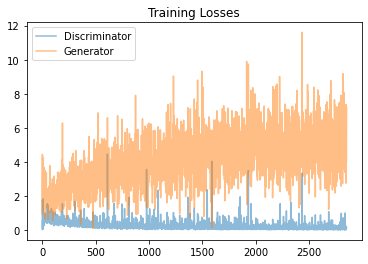

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

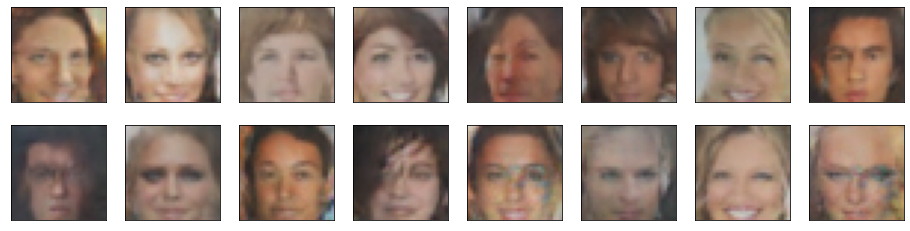

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
Generated faces are it seems only White not, Black or Asian.<br>
Because it may be dataset contains many white celebrities. So, add blacks and Asians to the data set.<br>
And faces are blurred. If image size is more larger it might be more clealy.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.